In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from nltk.corpus import stopwords
import json
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbEvalCallback, WandbModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

In [14]:
Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.utils.pad_sequences
Sequential = tf.keras.models.Sequential
Dense = tf.keras.layers.Dense
Embedding = tf.keras.layers.Embedding
LSTM = tf.keras.layers.LSTM
SpatialDropout1D = tf.keras.layers.SpatialDropout1D
EarlyStopping = tf.keras.callbacks.EarlyStopping
to_categorical = tf.keras.utils.to_categorical
Dropout = tf.keras.layers.Dropout

In [6]:
config_data = json.load(open('../config.json'))
HF_TOKEN = config_data['HF_TOKEN']
WANDB_TOKEN = config_data['WANDB_TOKEN']

wandb.login(key=WANDB_TOKEN)

run = wandb.init(
    project='wz_experimental',
    config={"model_name": "LSTM"}
)

wandb: Currently logged in as: kawishbit (kawishbit-org). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kawis\_netrc


In [15]:
id_to_label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
label_to_id_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
cefr_levels = ["A1", "A2", "B1", "B2", "C1", "C2"]

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [16]:
config = wandb.config

config.maxlen = 13000
config.vocab_size = 45000
config.embedding_dims = 100
config.epochs = 4
config.hidden_dims = 100
config.batch_size = 16

In [17]:
train = pd.read_csv('../datasets/montgomerie/train.csv')
test = pd.read_csv('../datasets/montgomerie/test.csv')

train['label'] = train['level'].apply(lambda x: label_to_id_mapping[x])
test['label'] = test['level'].apply(lambda x: label_to_id_mapping[x])

print(train['level'].value_counts())
print(test['level'].value_counts())

print(train["text"].str.len().max())
print(test["text"].str.len().max())

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

level
A1    230
B2    229
A2    217
C1    193
B1    164
C2    162
Name: count, dtype: int64
level
A1    58
B2    57
A2    55
C1    48
B1    41
C2    40
Name: count, dtype: int64
10212
12670


In [18]:
def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)  
    text = text.replace('x', '')
    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [19]:
train['cleaned_text'] = train['text'].apply(clean_text)
test['cleaned_text'] = test['text'].apply(clean_text)

train['cleaned_text'] = train['cleaned_text'].str.replace('\d+', '')
test['cleaned_text'] = test['cleaned_text'].str.replace('\d+', '')

In [20]:
tokenizer = Tokenizer(num_words=config.vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts( pd.concat([train['cleaned_text'], test['cleaned_text']], ignore_index=True).values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 41400 unique tokens.


In [21]:
X_train_raw = train['cleaned_text']
Y_train_raw = train['label']
X_test_raw = test['cleaned_text']
Y_test_raw = test['label']

X_train = tokenizer.texts_to_sequences(X_train_raw.values)
X_train = pad_sequences(X_train, maxlen=config.maxlen)

Y_train = pd.get_dummies(Y_train_raw).values


X_test = tokenizer.texts_to_sequences(X_test_raw.values)
X_test = pad_sequences(X_test, maxlen=config.maxlen)

Y_test = pd.get_dummies(Y_test_raw).values

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1195, 13000) (1195, 6)
(299, 13000) (299, 6)


In [22]:
model = Sequential()
model.add(Embedding(config.vocab_size, config.embedding_dims))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(config.hidden_dims, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
class WandbClfEvalCallback(WandbEvalCallback):
    def __init__(self, validation_data, data_table_columns, pred_table_columns):
        super().__init__(data_table_columns, pred_table_columns)

        self.x = validation_data[0]
        self.y = validation_data[1]

    def add_ground_truth(self, logs=None):
        for idx, (text, label) in enumerate(zip(self.x, self.y)):
            self.data_table.add_data(idx, text, label)

    def add_model_predictions(self, epoch, logs=None):
        preds = self.model.predict(self.x, verbose=0)
        preds = tf.argmax(preds, axis=-1)

        data_table_ref = self.data_table_ref
        table_idxs = data_table_ref.get_index()

        for idx in table_idxs:
            pred = preds[idx]
            self.pred_table.add_data(
                epoch,
                data_table_ref.data[idx][0],
                data_table_ref.data[idx][1],
                data_table_ref.data[idx][2],
                pred,
            )

history = model.fit(
    X_train,Y_train,
    epochs=config.epochs,
    batch_size=config.batch_size,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001), WandbMetricsLogger(),
               WandbClfEvalCallback(
                   validation_data=(X_train, Y_train),
                   data_table_columns=["idx", "text", "label"],
                   pred_table_columns=["epoch", "idx", "text", "label", "pred"],
               )]
)

wandb:   1 of 1 files downloaded.  


Epoch 1/4
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2243 - loss: 1.7698

wandb: ERROR Unable to log learning rate.


60/60 ━━━━━━━━━━━━━━━━━━━━ 541s 9s/step - accuracy: 0.2252 - loss: 1.7688 - val_accuracy: 0.3138 - val_loss: 1.5648
Epoch 2/4
60/60 ━━━━━━━━━━━━━━━━━━━━ 562s 9s/step - accuracy: 0.4212 - loss: 1.3493 - val_accuracy: 0.3933 - val_loss: 1.2692
Epoch 3/4
26/60 ━━━━━━━━━━━━━━━━━━━━ 4:22 8s/step - accuracy: 0.5175 - loss: 1.1384

KeyboardInterrupt: 

In [83]:
accuracy = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 0.6970 - loss: 1.0845
Test set
  Loss: 1.115
  Accuracy: 0.689


In [84]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
wandb.log({"Loss": plt})

C:\Users\kawis\anaconda3\Lib\site-packages\plotly\matplotlylib\renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [85]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
wandb.log({"Accuracy": plt})

In [86]:
import datetime 

def make_predictions(p_model, p_test):
    print(f'Started prediction at {datetime.datetime.now()}')
    for index, row in p_test.iterrows():
        sentence = row['cleaned_text']
        pred_sentence = tokenizer.texts_to_sequences([sentence])
        pred_sentence = pad_sequences(pred_sentence, maxlen=config.maxlen)
        pred = model.predict(pred_sentence)
        p_test.loc[index, 'predictions'] = cefr_levels[np.argmax(pred)]


make_predictions(model, test)
print(f'Ended prediction at {datetime.datetime.now()}')

Started prediction at 2024-08-18 03:09:01.829583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1

Accuracy: 0.689
Accuracy for label A1: 0.809
Accuracy for label A2: 0.691
Accuracy for label B1: 0.563
Accuracy for label B2: 0.673
Accuracy for label C1: 0.465
Accuracy for label C2: 0.000

Classification Report:
              precision    recall  f1-score   support

          A1       0.87      0.81      0.84       853
          A2       0.65      0.69      0.67       753
          B1       0.51      0.56      0.53       442
          B2       0.66      0.67      0.66       492
          C1       0.63      0.46      0.53       142
          C2       0.00      0.00      0.00        10

    accuracy                           0.69      2692
   macro avg       0.55      0.53      0.54      2692
weighted avg       0.69      0.69      0.69      2692


Confusion Matrix:
[[690 161   2   0   0   0]
 [105 520 122   6   0   0]
 [  1  99 249  93   0   0]
 [  0  17 110 331  34   0]
 [  0   0   5  71  66   0]
 [  0   0   1   4   5   0]]


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\U

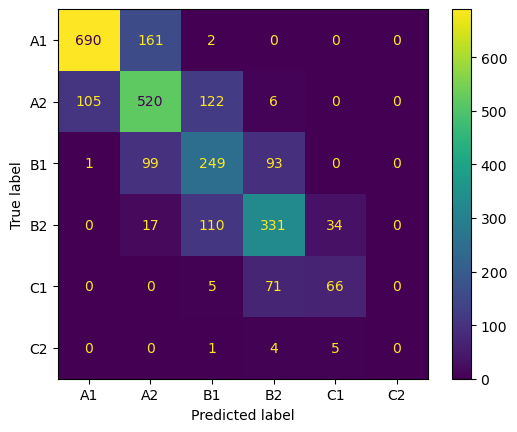

In [87]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = test['predictions']

y_true = test['level']

def map_func(x):
    return label_to_id_mapping.get(x, -1)

y_true_mapped = np.vectorize(map_func)(y_true)
y_pred_mapped = np.vectorize(map_func)(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
print(f'Accuracy: {accuracy:.3f}')

# Generate accuracy report
unique_labels = set(y_true_mapped)  # Get unique labels

for label in unique_labels:
    label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
    label_y_true = [y_true_mapped[i] for i in label_indices]
    label_y_pred = [y_pred_mapped[i] for i in label_indices]
    label_accuracy = accuracy_score(label_y_true, label_y_pred)
    print(f'Accuracy for label {cefr_levels[label]}: {label_accuracy:.3f}')

class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))))
class_report_dict = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))), output_dict=True)
print('\nClassification Report:')
print(class_report)
table_data = []

for key, value in class_report_dict.items():
    if isinstance(value, dict):
        table_data.append([
            key,
            value.get("precision", 0),
            value.get("recall", 0),
            value.get("f1-score", 0),
            value.get("support", 0)
        ])
    else:
        # For accuracy, add precision and recall as 0
        table_data.append([
            key,
            0,
            0,
            value,
            class_report_dict["weighted avg"]["support"]
        ])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(cefr_levels))))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=cefr_levels)
disp.plot()


print('\nConfusion Matrix:')
print(conf_matrix)

wandb.log({
    "Class Proportions": wandb.sklearn.plot_class_proportions(train['level'], test['level'], cefr_levels),
    "Confusion Matrix": plt,
    "Classification Report": wandb.Table(data=table_data, columns=['Class/Metric', 'Precision', 'Recall', 'F1-score', 'Support'])
})

In [24]:
wandb.finish()

epoch/accuracy,▁█
epoch/epoch,▁█
epoch/loss,█▁
epoch/val_accuracy,▁█
epoch/val_loss,█▁
epoch/accuracy,0.44665
epoch/epoch,1
epoch/loss,1.29076
epoch/val_accuracy,0.39331
epoch/val_loss,1.26925
